# Inference example for trained 2D U-Net model on BraTS.
Takes a trained model and performs inference on a few validation examples.

In [1]:
import sys
print (sys.version)
print ("Path to the python executable:", sys.executable)

3.6.5 |Intel Corporation| (default, Aug  3 2018, 14:28:11) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Path to the python executable: /opt/anaconda/envs/idp/bin/python


In [2]:
%matplotlib inline
import os
import psutil
import numpy as np
import keras as K
import h5py
import time
import tensorflow as tf 
import sys; sys.argv=['']; del sys

from argparser import args

if args.keras_api:
    import keras as K
else:
    from tensorflow import keras as K

import matplotlib.pyplot as plt

onnx=False
#TODO - Enable nGraph Bridge - Switch to (decathlon) venv!
# import ngraph_bridge

if onnx:
    #TODO - Include ngraph onnx backend
    import onnx
    from ngraph_onnx.onnx_importer.importer import import_onnx_model
    import ngraph as ng

print ("We are using Tensorflow version", tf.__version__,\
       "with Intel(R) MKL", "enabled" if tf.pywrap_tensorflow.IsMklEnabled() else "disabled",)

Using TensorFlow backend.


We are using Tensorflow version 1.12.0 with Intel(R) MKL enabled


In [3]:
# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)
    
data_fn = os.path.join(args.data_path, args.data_filename)
model_fn = os.path.join(args.output_path, args.inference_filename)

#### Define the DICE coefficient and loss function

The Sørensen–Dice coefficient is a statistic used for comparing the similarity of two samples. Given two sets, X and Y, it is defined as

\begin{equation}
dice = \frac{2|X\cap Y|}{|X|+|Y|}
\end{equation}

In [5]:
def calc_dice(y_true, y_pred, smooth=1.):
    """
    Sorensen Dice coefficient
    """
    numerator = 2.0 * np.sum(y_true * y_pred) + smooth
    denominator = np.sum(y_true) + np.sum(y_pred) + smooth
    coef = numerator / denominator

    return coef

def dice_coef(y_true, y_pred, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true + y_pred, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_coef_loss(target, prediction, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.log(2.*numerator) + tf.log(denominator)

    return dice_loss


def combined_dice_ce_loss(y_true, y_pred, axis=(1, 2), smooth=1.,
                          weight=0.9):
    """
    Combined Dice and Binary Cross Entropy Loss
    """
    return weight*dice_coef_loss(y_true, y_pred, axis, smooth) + \
        (1-weight)*K.losses.binary_crossentropy(y_true, y_pred)

## Inference Time!

Inferencing in this example can be done in 3 simple steps:
1. Load the data
1. Load the Keras model 
1. Perform a `model.predict` on an input image (or set of images)

#### Step 1 : Load data

In [6]:
df = h5py.File(data_fn, "r")
imgs_validation = df["imgs_validation"]
msks_validation = df["msks_validation"]

#### Step 2 : Load the model

In [7]:
model = K.models.load_model(model_fn, custom_objects={
"combined_dice_ce_loss": combined_dice_ce_loss,
"dice_coef_loss": dice_coef_loss,
"dice_coef": dice_coef})

#### Step 3 (final step): Perform prediction with `model.predict`

We first define a convenience function that performs a prediction on one image. This function takes an image ID and a flag `plot_result` which we can use to toggle displaying the results graphically. 

After we have performed a prediction, we calculate the dice score to analyze how good out prediction was compared to the ground truth. 

In [8]:
def predict(img_no, plot_result):
    """
    Calculate the Dice and plot the predicted masks for image # img_no
    """

    img = imgs_validation[[img_no], ]
    msk = msks_validation[[img_no], ]
    
    #TODO load onnx model in ngraph
    if onnx:
        onnx_protobuf = onnx.load('./output/unet_model_for_decathlon_100_iter.onnx')
        ng_models = import_onnx_model(onnx_protobuf)
        ng_model = ng_models[0]
        runtime = ng.runtime(backend_name='CPU')
        unet = runtime.computation(ng_model['output'], *ng_model['inputs'])
        
        start_time = time.time()
        pred_mask= unet(img)[0]
        print ("Time for prediction ngraph: ", '%.0f'%((time.time()-start_time)*1000),"ms")

    else:
        start_time = time.time()
        pred_mask = model.predict(img, verbose=0, steps=None)
        print ("Time for prediction TF: ", '%.0f'%((time.time()-start_time)*1000),"ms")
        
    dice_score = calc_dice(pred_mask, msk)

    print("Dice score for Image #{} = {:.4f}".format(img_no,
                                                     dice_score))
    if plot_result:
        plt.figure(figsize=(15, 15))
        plt.subplot(1, 3, 1)
        plt.imshow(img[0, :, :, 0], cmap="bone", origin="lower")
        plt.axis("off")
        plt.title("MRI Input", fontsize=20)
        plt.subplot(1, 3, 2)
        plt.imshow(msk[0, :, :, 0], origin="lower")
        plt.axis("off")
        plt.title("Ground truth", fontsize=20)
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0, :, :, 0], origin="lower")
        plt.axis("off")
        plt.title("Prediction\nDice = {:.4f}".format(dice_score), fontsize=20)

        plt.tight_layout()

        png_name = os.path.join(png_directory, "pred{}.png".format(img_no))
        plt.savefig(png_name, bbox_inches="tight", pad_inches=0)
        print("Saved png file to {}".format(png_name))

#### Step 3 (continued) : Perform prediction on some images. 
Use `plot_result=True/False` to toggle plotting the results. If `plot_result=True`, the prediction results will be saved in the output directory for images, which is defined by the `png_directory` variable.

Time for prediction TF:  536 ms
Dice score for Image #40 = 0.8816
Saved png file to inference_examples/pred40.png
Time for prediction TF:  139 ms
Dice score for Image #63 = 0.8267
Saved png file to inference_examples/pred63.png
Time for prediction TF:  120 ms
Dice score for Image #43 = 0.8666
Saved png file to inference_examples/pred43.png
Time for prediction TF:  122 ms
Dice score for Image #55 = 0.7470
Saved png file to inference_examples/pred55.png
Time for prediction TF:  118 ms
Dice score for Image #99 = 0.9030
Saved png file to inference_examples/pred99.png
Time for prediction TF:  123 ms
Dice score for Image #101 = 0.8997
Saved png file to inference_examples/pred101.png
Time for prediction TF:  120 ms
Dice score for Image #19 = 0.9905
Saved png file to inference_examples/pred19.png
Time for prediction TF:  118 ms
Dice score for Image #46 = 0.8103
Saved png file to inference_examples/pred46.png


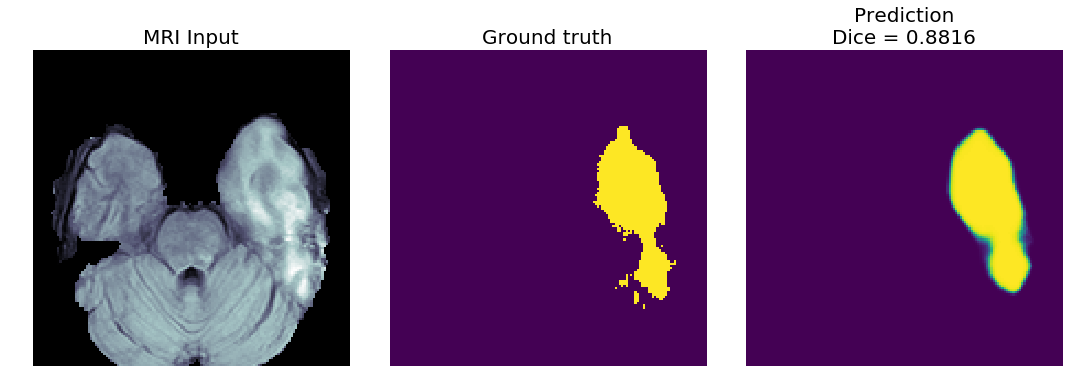

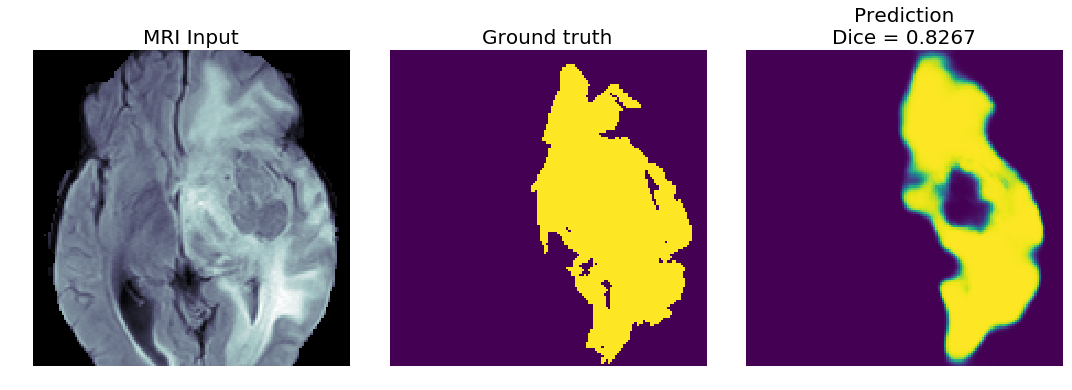

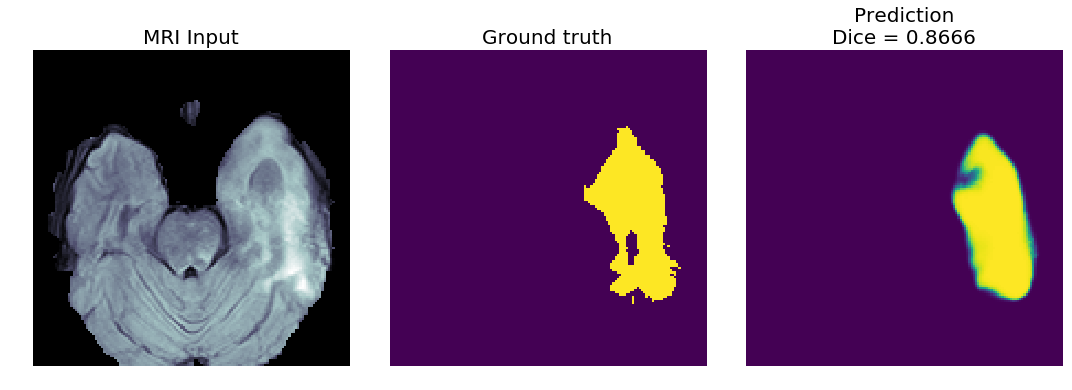

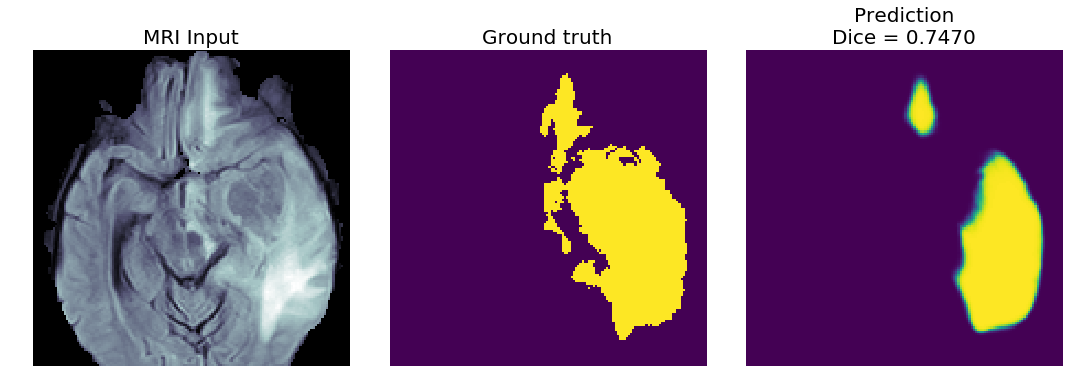

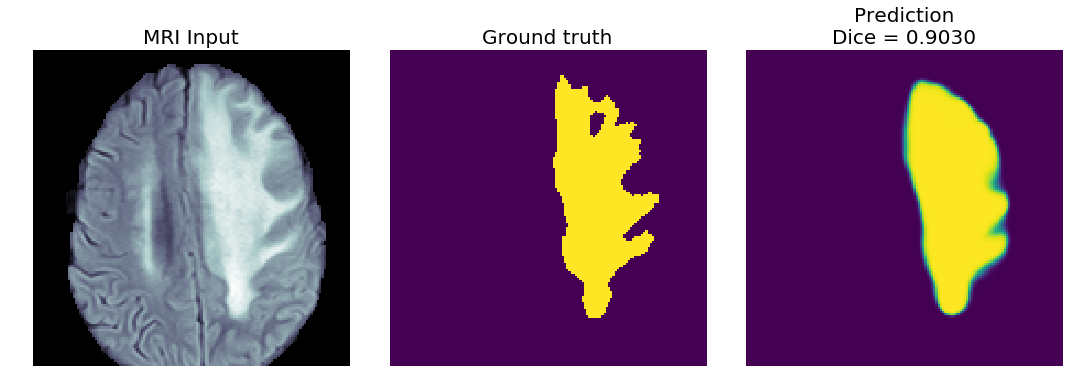

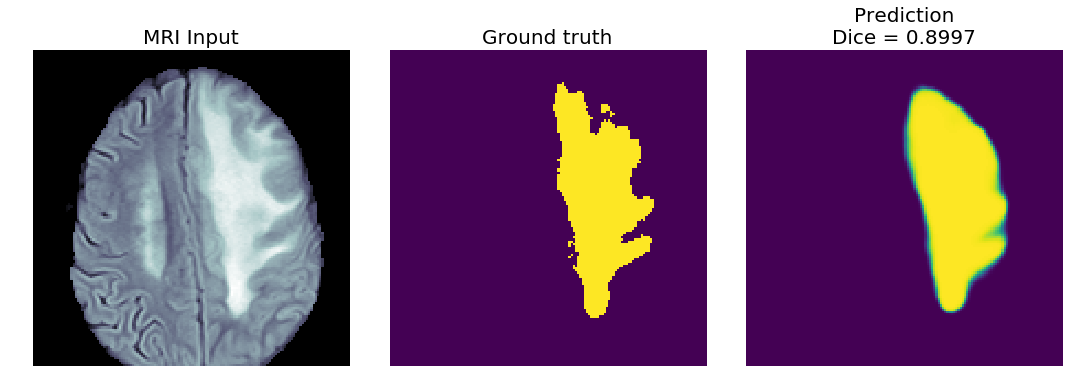

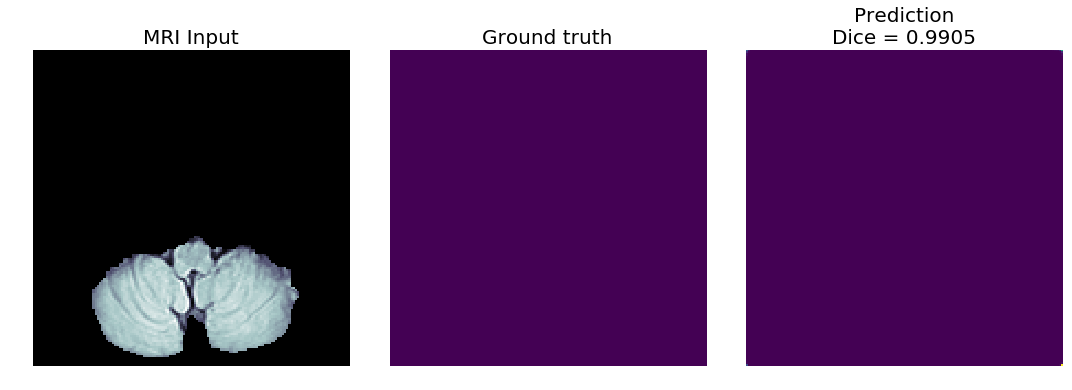

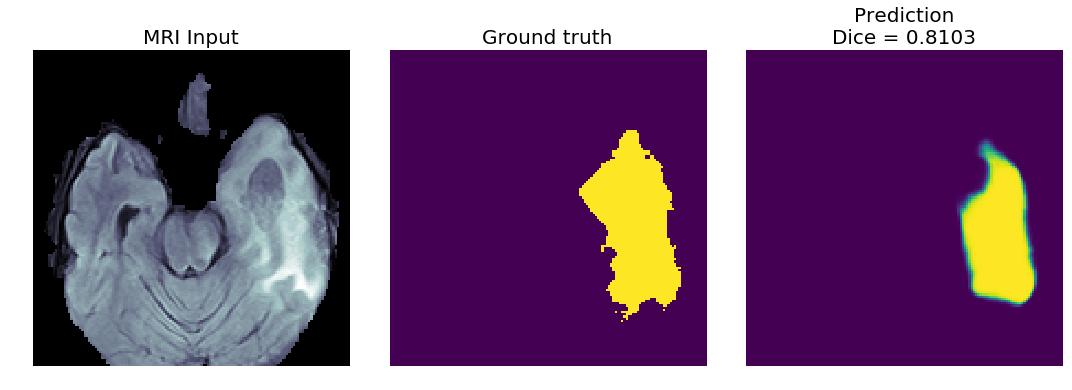

In [9]:
indicies_validation = [40, 63, 43, 55, 99, 101, 19, 46] #[40]

for idx in indicies_validation:
    predict(idx, plot_result=True)

`Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0`